In [ ]:
## Celiac vs EE vs Normal

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import skimage

In [30]:
PATH = "/scratch/kk4ze/data_lowres_1100x1100_augmented/"
sz = 1100
arch = resnet34
bs = 8

In [31]:
m = arch(True)

In [32]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [33]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 512, 3, 1, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [34]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.from_model_data(m, data)

In [22]:
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
# # Visualising the augmentation
# def get_augs():
#     data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
#     x,_ = next(iter(data.aug_dl))
#     return data.trn_ds.denorm(x)[1]
# ims = np.stack([get_augs() for i in range(6)])
# plots(ims, rows=2)


In [23]:
# data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
# learn = ConvLearner.from_model_data(m, data)

In [35]:
learn.freeze_to(-4)

In [36]:
m[-1].trainable

True

In [37]:
m[-4].trainable

True

In [38]:
learn.fit(0.0005, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      1.028062   0.628705   0.751445  
    1      0.796851   0.954973   0.606936                  
    2      0.782581   0.774091   0.716763                  


[0.7740911582990878, 0.7167630057803468]

## Class Activation Maps (CAM)

In [39]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [40]:
x,y = next(iter(data.val_dl))

In [41]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

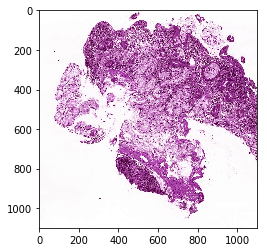

In [42]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [43]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [44]:
%time py = m(Variable(x.cuda()))

CPU times: user 4.99 ms, sys: 0 ns, total: 4.99 ms
Wall time: 4.74 ms


In [45]:
for o in sfs: o.remove()

In [46]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 138, 138]),
 torch.Size([1, 256, 69, 69]),
 torch.Size([1, 512, 35, 35]),
 torch.Size([1, 512, 35, 35])]

In [47]:
py = np.exp(to_np(py)[0]); py

array([0.66949, 0.06719, 0.26331, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0. 

In [48]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(512, 35, 35)

In [49]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.00141, 0.02176, 0.00989, ..., 0.00207, 0.02154, 0.01625],
       [0.02063, 0.04666, 0.03642, ..., 0.03108, 0.04852, 0.04216],
       [0.0083 , 0.037  , 0.03655, ..., 0.04278, 0.04791, 0.03545],
       ...,
       [0.10436, 0.20834, 0.24758, ..., 0.07274, 0.10537, 0.07709],
       [0.17288, 0.29988, 0.32746, ..., 0.10112, 0.14069, 0.10464],
       [0.13275, 0.24038, 0.25475, ..., 0.07044, 0.0987 , 0.07049]], dtype=float32)

In [51]:
from skimage.transform import*

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


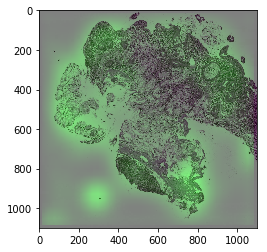

In [52]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [40]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.02049  0.01577  0.99405]                         
[ 1.       0.01648  0.0137   0.99554]                          



In [41]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.996

In [42]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.01243  0.01535  0.99554]                          
[ 1.       0.0128   0.01507  0.99554]                          



In [43]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.99650000000000005